# B.1. The FX Carry Trade

## Module B: FX, Commodities, and Equities

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

# Data

`fx_carry_data.xlsx`.
- It reports the risk-free rates in a monthly scaling.
- It also pulls the LIBOR data from 1-month LIBOR instead of the original 3-month LIBOR. Thus, this set is more appropriate for our one-month trade-horizon considerations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, '../cmds')
from portfolio import *

pd.set_option("display.precision", 4)

In [2]:
DATAPATH_FX = '../data/fx_carry_data.xlsx'
USDRF = 'USD1M'

SHEET = 'fx rates'
fx = pd.read_excel(DATAPATH_FX, sheet_name=SHEET).set_index('DATE')

logFX = np.log(fx)
logFX

,USUK,USEU,USSZ,USJP
DATE,,,,
1999-01-31,0.4982,0.1285,-0.3484,-4.7536
1999-02-28,0.4717,0.0949,-0.3712,-4.7766
1999-03-31,0.4787,0.0777,-0.3904,-4.7743
1999-04-30,0.4753,0.0549,-0.4225,-4.7827
1999-05-31,0.4713,0.0413,-0.4240,-4.7948
...,...,...,...,...
2021-06-30,0.3225,0.1696,0.0776,-4.7100
2021-07-31,0.3302,0.1709,0.0986,-4.6977
2021-08-31,0.3182,0.1655,0.0876,-4.7009


In [3]:
SHEET = 'risk-free rates'

rf = pd.read_excel(DATAPATH_FX,sheet_name=SHEET).set_index('DATE')

logRF = np.log(rf+1)
logRFusd = logRF[[USDRF]]
logRF.drop(columns=[USDRF],inplace=True)

logRF

,GBP1M,EUR1M,CHF1M,JPY1M
DATE,,,,
1999-01-31,4.9255e-03,0.0026,0.0010,3.3458e-04
1999-02-28,4.6137e-03,0.0026,0.0010,2.3226e-04
1999-03-31,4.4241e-03,0.0025,0.0010,1.4270e-04
1999-04-30,4.3944e-03,0.0021,0.0008,9.8953e-05
1999-05-31,4.4106e-03,0.0021,0.0008,7.4997e-05
...,...,...,...,...
2021-06-30,4.5615e-05,-0.0005,-0.0007,-5.0143e-05
2021-07-31,4.3355e-05,-0.0005,-0.0007,-5.3335e-05
2021-08-31,4.2122e-05,-0.0005,-0.0007,-5.9310e-05


Timing of the risk-free rate
- The data is defined such that the March value of the risk-free rate corresponds to the rate beginning in March and ending in April.
- In terms of the class notation, $r^{f,i}_{t,t+1}$ is reported at time $t$. (It is risk-free, so it is a rate from $t$ to $t+1$ but it is know at $t$.

# The Static Carry Trade

Calculate excess log returns using,
$$\tilde{r}^i_{t+1} \equiv s^i_{t+1} - s^i_t + r^{f,i}_{t,t+1} - r^{f,\$}_{t,t+1}$$
For convenience, rewrite this as
$$\tilde{r}^i_{t+1} \equiv s^i_{t+1} - s^i_t - (r^{f,\$}_{t,t+1} - r^{f,i}_{t,t+1})$$

1. Build the spread in risk-free rates: $r^{f,\$}_{t,t+1} - r^{f,i}_{t,t+1}$.
- Lag this variable, so that the March-to-April value is stamped as April.

2. Build the FX growth rates: $ s^i_{t+1} - s^i_t$
- These are already stamped as April for the March-to-April FX growth.

Then the excess log return is simply the difference of the two objects.

In [1]:
logRFspread = -logRF.subtract(logRFusd.values,axis=0)
logRFspread = logRFspread.shift(1)

logFXgrowth = logFX.diff(axis=0)

logRX = logFXgrowth - logRFspread.values
logRX

NameError: name 'logRF' is not defined

### Understanding the two components of excess log returns

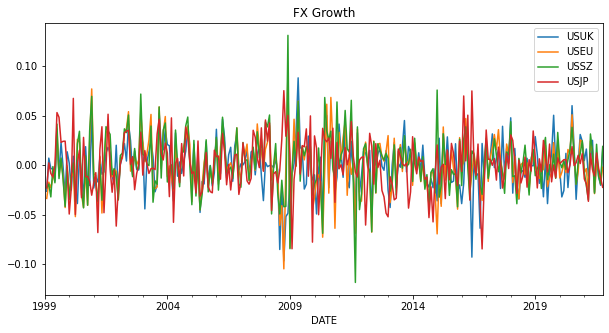

In [5]:
logFXgrowth.plot(title='FX Growth', figsize=(10,5));

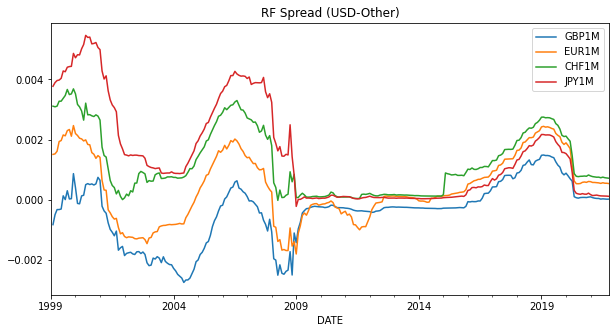

In [6]:
logRFspread.plot(title='RF Spread (USD-Other)', figsize=(10,5));

In [7]:
rx_components = logFXgrowth.mean().to_frame()
rx_components.columns=['FX effect']
rx_components['RF effect'] = -logRFspread.mean().values
rx_components['Total'] = rx_components.sum(axis=1)
rx_components *= 12
rx_components

,FX effect,RF effect,Total
USUK,-0.0081,0.0046,-0.0035
USEU,0.0007,-0.0050,-0.0044
USSZ,0.0191,-0.0148,0.0043
USJP,0.0008,-0.0182,-0.0174


### Performance Metrics

Remember these are log returns, not level returns. But the distinction is minor for the quantitative results here.

In [8]:
performanceMetrics(logRX,annualization=12)

,Mean,Vol,Sharpe,Min,Max
USUK,-0.0035,0.0863,-0.0406,-0.0949,0.0883
USEU,-0.0044,0.0947,-0.0459,-0.1037,0.0935
USSZ,0.0043,0.0988,0.0437,-0.1185,0.1300
USJP,-0.0174,0.0915,-0.1903,-0.0850,0.0743


## Implications for UIP

The results above are evidence against UIP, but not strong evidence.
- UIP implies that the mean excess return should be zero. The USD and JPY trade seems to have a mean excess return significantly different from zero.)

- The evidence from the other currencies is not clear. Their mean excess return is not exactly zero, but they are so close to zero that they may not be statistically significant.

- Note that UIP makes no implication about the volatility of these excess returns.

A long position in three of the currencies had negative mean excess (log) returns!
- Being long CHF would have delivered a small positive mean excess log return, but a poor Sharpe.
- The best trade would have been to be short JPY and long USD. This delivered a small but positive mean return and Sharpe.

# Predicting FX

Run a forecasting regression for the log FX Growth, as implied by UIP.
- UIP implies that the interest rate spread is the optimal predictor of FX growth.
- Thus, it implies the forecasting beta should be 1.

In [9]:
olstab = pd.DataFrame(index=logFXgrowth.columns, columns=['alpha','Beta','r-squared'])
for i, curncy in enumerate(logFXgrowth.columns):
    temp = get_ols_metrics(logRFspread.iloc[:,i],logFXgrowth.iloc[:,i],annualization=1).drop(columns=['Treynor Ratio','Info Ratio'])
    temp.rename(columns={logRFspread.columns[i]:'Beta'}, inplace=True)
    olstab.loc[curncy,:] = temp.values

olstab.T

,USUK,USEU,USSZ,USJP
alpha,-0.0005,0.0006,0.0036,-0.0005
Beta,0.4858,-1.2564,-1.6466,0.3715
r-squared,0.0004,0.0026,0.0039,0.0005


#### Predicting Appreciation or Depreciation?

Look at whether the betas are positive or negative.

If the regressor (USD minus foreign risk-free rate) goes DOWN, then we expect 
- decreased UK and JP relative to US.
- increased EU and SZ relative to US. (That is, the expected FX growth is higher.)

Thus, if UK risk-free rate increases relative to US risk-free rate, we expect USD will appreciate.
- This means FX growth is partially offsetting the interest-rate differential. But not fully. Beta is positive, but less than one.

For EU and SZ,
- this means that FX growth is exacerbating the returns from the interest rate differentials. Beta is negative, so in a sense, investors expect to gain twice: immediately from the risk-free rate differential, and again from the FX movement at the close of the position.

In fact, the statements above are just about the point estimates, and may not be statistically significant.

#### Strength of Predictability?
These effects are extremely small! The R-squared stats for all four currencies are nearly 0. 

# The Dynamic Carry Trade

In [10]:
forecast = pd.DataFrame(columns=logFXgrowth.columns, index=logFXgrowth.index)
for i, curncy in enumerate(logFXgrowth.columns):
    forecast[curncy] = olstab.loc[curncy,'alpha'] + (olstab.loc[curncy,'Beta']-1) * logRFspread.iloc[:,i]

forecast

,USUK,USEU,USSZ,USJP
DATE,,,,
1999-01-31,NaN,NaN,NaN,NaN
1999-02-28,-6.8394e-05,-0.0028,-0.0046,-0.0029
1999-03-31,-2.3875e-04,-0.0029,-0.0046,-0.0029
1999-04-30,-3.2543e-04,-0.0031,-0.0046,-0.0030
1999-05-31,-3.2588e-04,-0.0038,-0.0050,-0.0030
...,...,...,...,...
2021-06-30,-5.0427e-04,-0.0007,0.0017,-0.0006
2021-07-31,-5.0863e-04,-0.0007,0.0016,-0.0006
2021-08-31,-5.0551e-04,-0.0007,0.0017,-0.0006


### Forecast timing
We do not need to lag the forecasts with `.shift()` because we already use the lagged calculation of the interest rate spread. 

Thus, the regressor is lagged, and thus is generating forecasts stamped with the date of their targeted value, as desired.

In [11]:
forecast_positive = ((forecast.dropna() > 0).sum() / forecast.dropna().shape[0]).to_frame().T
forecast_positive.index = ['fraction with positive forecastium']
forecast_positive

,USUK,USEU,USSZ,USJP
fraction with positive forecastium,0.2381,0.5018,0.63,0.0


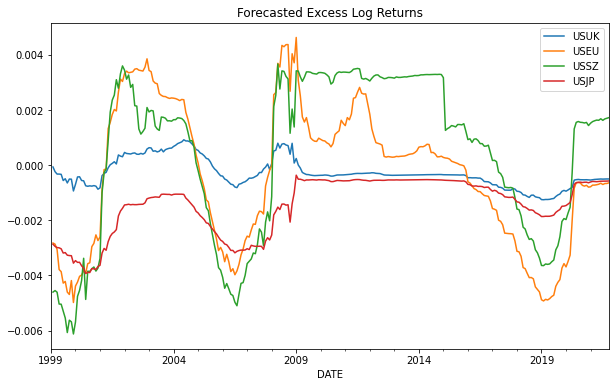

In [12]:
forecast.plot(title='Forecasted Excess Log Returns', figsize=(10,6));

#### Positive or Negative Forecasts?

Though the static carry-trade above found that UK and EU have negative mean excess (log) returns, the dynamic carry trade finds that the time-varying forecast is often positive.

For JP, the forecast is negative throughout the sample due to the much higher interest rate in USD not being offset by appreciation of the Yen to the USD.

#### Improving the Trade?

We can use forecasts of excess returns to construct trading positions, (weights,) which vary with the forecasts. The resulting trading strategy should be better than the static carry trade.

That is, we could time the magnitude and direction of the currency trades instead of being passively 100\% invested in a currency according to the evidence above.

It is analagous to timing the trading of SPY according to the Earnings-Price Ratio instead of being passively 100\% invested in SPY.

Of course, it is an open question as to whether this will work given the weak R-squared in-sample, let alone out-of-sample.

# Building the Dynamic Trade

Try implementing the forecasts with a simple proportional weighting of each forecast.

In [13]:
passive = logRX
forecast_baseline = logRX.expanding().mean().shift(1)

wts = 100 * forecast
forecast_returns = wts * passive.values
forecast_returns

,USUK,USEU,USSZ,USJP
DATE,,,,
1999-01-31,NaN,NaN,NaN,NaN
1999-02-28,0.0002,9.9311e-03,0.0119,0.0077
1999-03-31,-0.0002,5.3562e-03,0.0101,0.0005
1999-04-30,0.0001,7.4887e-03,0.0162,0.0037
1999-05-31,0.0001,5.8593e-03,0.0024,0.0048
...,...,...,...,...
2021-06-30,0.0014,1.9275e-03,-0.0049,0.0007
2021-07-31,-0.0004,-5.4750e-05,0.0033,-0.0007
2021-08-31,0.0006,3.9923e-04,-0.0020,0.0002


## Check the performance

#### Also compare to the equally-weighted combination of the currency trades

All stats are **much** better than the static carry trade.
- But this is an in-sample performance.
- Open question whether the OOS version can beat the static table.

Note that currencies have low means and low vols, so in no case are we expecting to get equity-like return statistics.

In [14]:
forecast_returns['Equally-Weighted'] = forecast_returns.mean(axis=1) * 10

performanceMetrics(forecast_returns,annualization=12)

,Mean,Vol,Sharpe,Min,Max
USUK,0.0004,0.0050,0.0840,-0.0060,0.0049
USEU,0.0076,0.0241,0.3166,-0.0378,0.0347
USSZ,0.0100,0.0283,0.3530,-0.0373,0.0257
USJP,0.0037,0.0165,0.2251,-0.0220,0.0218
Equally-Weighted,0.0545,0.1356,0.4017,-0.1684,0.1486


### How correlated are the active (forecasted) implementations to the passive returns?

- Not all that correlated.
- Note that we're interested in the magnitude, not the sign.
- The active version is shorting JP, so no surprise that the correlation is negative.

In [15]:
corr_tab = forecast_returns.corrwith(passive,drop='missing',axis=0).to_frame().T
corr_tab.index = ['Corr. Passive to Active']
corr_tab

,USUK,USEU,USSZ,USJP
Corr. Passive to Active,-0.3961,0.2602,0.3772,-0.8106
